# QLearningDynamicProgramming
## Reinforcement Q-Learning for World Grid Navigation
    ## Q-Learning + Dynamic Programming (Full Implementation)
    ## QL Helper Functions (Full Implementation)
    ## Author: Samyuel Danyo
    ## Date: 18/4/2019
    ## License: MIT License
    ## Copyright (c) 2020 Samyuel Danyo

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
import time
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator
np.random.seed(seed=1)
import scipy.io
import warnings
import os, sys, operator

## Dataset Preprocessing Functions 

In [2]:
def load_dataset_mat(fname, tr_key_X=None, tr_key_T=None, te_key_X=None,
                     te_key_T=None, val_key_X=None, val_key_T=None, transpose=False):
    """ Get the Dataset into NumPy arrays. """
    out = ()
    if tr_key_X:
        TRAIN_DICT = scipy.io.loadmat(fname)
        X_TRAIN = np.array(TRAIN_DICT[tr_key_X])
        X_TRAIN = X_TRAIN.T if transpose else X_TRAIN   
        T_TRAIN = np.array(TRAIN_DICT[tr_key_T])
        T_TRAIN = T_TRAIN.reshape(T_TRAIN.shape[0])
        out = out + (X_TRAIN, T_TRAIN)
    
    if val_key_X:
        VAL_DICT = scipy.io.loadmat(fname)
        X_VAL = np.array(VAL_DICT[val_key_X])
        X_VAL = X_VAL.T if transpose else X_VAL   
        T_VAL = np.array(VAL_DICT[val_key_T])
        T_VAL = T_VAL.reshape(T_VAL.shape[0])
        out = out + (X_VAL, T_VAL)
    
    if te_key_X:
        TEST_DICT = scipy.io.loadmat(fname)
        X_TEST = np.array(TEST_DICT[te_key_X])
        X_TEST = X_TEST.T if transpose else X_TEST   
        T_TEST = np.array(TEST_DICT[te_key_T])
        T_TEST = T_TEST.reshape(T_TEST.shape[0])
        out = out + (X_TEST, T_TEST)
    return out

## Q-Learning Parameter Control Functions

In [3]:
def k_decay(par=1, k=1):
    return 1.0 / k

def const_k_decay(par=1, k=1, const=100):
    return const / (const + k)

def log_k_decay(par=1, k=1):
    return (1.0 + np.log(k)) / k

def const_log_k_decay(par=1, k=1, const=5):
    return (1.0 + const*np.log(k)) / k

def const(par=1, k=1, const=0.99):
    return const

def const_decay(epsilon=1, k=1, decay_rate=0.99):
    return epsilon*decay_rate

## Environment Class

In [4]:
class Environment:
    """ Environment Class for the Q-Learning Class. """
    def __init__(self, state_grid_dim=(10,10), goal_state=(9,9), R_table=np.empty(0),
                 idle_state=(0, 0), action_trans_conf='standard'):
        """ Args:
                state_grid_dim    (Tuple): Dimensions of the World Grid
                goal_state        (Tuple): Coordinates=(row,col) of the goal state
                R_table           (Numpy Matrix): Reward table
                idle_state        (Tuple): Coordinates=(row,col) of the starting state
                action_trans_conf (String): Action transition configuration:
                    standard - Illegal actions will be assed based on world boundaries & obstacles.
                    reward   - Illegal actions will be assed based on the reward table
                               (-1) rewards will be trated as illegal actions. """
        # Define state space (the gird world)
        self.state_grid_dim = state_grid_dim
        self.goal_state = goal_state
        self.idle_state = idle_state
        self.state = idle_state
        self.obstacle_state = None
       
        # Define action space
        self.action_dim = (4,)
        self.action_dict = {"up": 0, "right": 1, "down": 2, "left": 3}
        self.action_coords = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.action_trans_conf = action_trans_conf
        
        # Define reward table
        if R_table.size != 0:
            if R_table.shape != (state_grid_dim + self.action_dim):
                self.R = R_table.reshape(self.state_grid_dim + self.action_dim).transpose(1,0,2)
            else: self.R = R_table
        else:
            print("\nNo Reward Table Provided!")
            self.R = self._build_reward_table()
        
        # Check action space consistency
        if len(self.action_dict.keys()) != len(self.action_coords):
            raise ValueError("Inconsistent Action Space!")

    def reset(self):
        """ Reset the agent state. """
        self.state = self.idle_state  
        return self.state

    def step(self, action):
        """ Calculate next state, reward and
            success based on the agent's action. """
        # Compute the next agent location (state)
        state_next = (self.state[0] + self.action_coords[action][0],
                      self.state[1] + self.action_coords[action][1])
        
        # Collect reward
        reward = self.R[self.state + (action,)]
        
        # Terminate if we reach the goal state
        success = (np.array(state_next) == (np.array(self.goal_state))).all()
        
        # Update the agent location (state)
        self.state = state_next
        return state_next, reward, success
    
    def allowed_actions(self):
        """ Generate list of actions allowed
            depending on agent's location. """
        actions_allowed = []
        (y, x) = self.state
        
        if self.action_trans_conf is 'standard':
            # Restricting top boundary
            if (y > 0):
                actions_allowed.append(self.action_dict["up"])
            # Restricting bottom boundary
            if (y < self.state_grid_dim[1] - 1):
                actions_allowed.append(self.action_dict["down"])
            # Restricting left boundary
            if (x > 0):
                actions_allowed.append(self.action_dict["left"])
            # Restricting right boundary
            if (x < self.state_grid_dim[0] - 1):
                actions_allowed.append(self.action_dict["right"])
        
        elif self.action_trans_conf is 'reward':
            # Restricting obstacle from top
            if self.R[y,x,self.action_dict["up"]] != -1:
                actions_allowed.append(self.action_dict["up"])
            # Restricting obstacle from down
            if self.R[y,x,self.action_dict["down"]] != -1:
                actions_allowed.append(self.action_dict["down"])
            # Restricting obstacle from left
            if self.R[y,x,self.action_dict["left"]] != -1:
                actions_allowed.append(self.action_dict["left"])
            # Restricting obstacle from right
            if self.R[y,x,self.action_dict["right"]] != -1:
                actions_allowed.append(self.action_dict["right"])
        
        actions_allowed = np.array(actions_allowed, dtype=int)
        return actions_allowed

    def _build_reward_table(self):
        """ Define agent reward table R[s,a]. """
        print("Building Reward Table Based on Goal State With 1 Obstacle...")
        # Reward for arriving at goal state
        r_goal = 100
        # Penalty for reaching non-goal state
        r_nongoal = -0.1
        
        # Reward table: R[s,a]
        R_table = r_nongoal * np.ones(self.state_grid_dim + self.action_dim, dtype=float)
        
        # Goal state rewards
        # Enter goal state from top
        if self.goal_state[0] > 0:
            R_table[self.goal_state[0] - 1, self.goal_state[1], self.action_dict["down"]] = r_goal
        # Enter goal state from left
        if self.goal_state[1] > 0:
            R_table[self.goal_state[0], self.goal_state[1] - 1, self.action_dict["right"]] = r_goal
        # Enter goal state from right
        if self.goal_state[1] < self.state_grid_dim[1]-1:
            R_table[self.goal_state[0], self.goal_state[1]+1, self.action_dict["left"]] = r_goal
        # Enter goal state from down
        if self.goal_state[0] < self.state_grid_dim[0]-1:
            R_table[self.goal_state[0]+1, self.goal_state[1], self.action_dict["up"]] = r_goal
        
        # Get a random obstacle coordinates
        obstacle_row = np.random.choice(np.setdiff1d(np.arange(self.state_grid_dim[0]), self.goal_state[0]-1))
        obstacle_col = np.random.choice(np.setdiff1d(np.arange(self.state_grid_dim[1]), self.goal_state[1]-1))
        self.obstacle_state = (obstacle_row, obstacle_col)
        
        # Obstacle rewards
        # Encounter obstacle state from top
        if obstacle_row > 0:
            R_table[obstacle_row - 1, obstacle_col, self.action_dict["down"]] = -1
        # Encounter obstacle state from left
        if obstacle_col > 0:
            R_table[obstacle_row, obstacle_col - 1, self.action_dict["right"]] = -1
        # Encounter obstacle state from right
        if obstacle_col < self.state_grid_dim[1]-1:
            R_table[obstacle_row, obstacle_col+1, self.action_dict["left"]] = -1
        # Encounter obstacle state from down
        if obstacle_row < self.state_grid_dim[0]-1:
            R_table[obstacle_row+1, obstacle_col, self.action_dict["up"]] = -1
        
        return R_table

## Agent Class

In [5]:
class Agent:
    """ Agent Class for the Q-Learning Class. """
    def __init__(self):
        pass
        
    def get_action(self, env, Q, epsilon, explore_count, exploit_count):
        """ Aply Epsilon-greedy agent policy to make an action.
            Args:
                env (Environment class): The Q-Learning environment
                Q   (Numpy Matrix): The Q-function[s,a] of the algorithm.
                epsilon (Float): The current exploration probability
                explore_count (Integer): Number of explorations
                exploit_count (Integer): Number of exploitations """ 
        if np.random.uniform(0, 1) < epsilon:
            # Perform exploration
            explore_count +=1
            state = env.state
            # Get the allowed actions
            actions_allowed = env.allowed_actions()
            # Get the Q-values for the current state
            Q_s = Q[state[0], state[1], actions_allowed]
            # Pick from allowed actions without the highest Q-value
            actions_explore = actions_allowed[np.flatnonzero(Q_s != np.max(Q_s))]
            if actions_explore.size != 0:
                # If all Q-values are the same
                return (np.random.choice(actions_explore), explore_count, exploit_count)
            return (np.random.choice(actions_allowed), explore_count, exploit_count)
        else:
            # Perform exploitation
            exploit_count +=1
            state = env.state
             # Get the allowed actions
            actions_allowed = env.allowed_actions()
             # Get the Q-values for the current state
            Q_s = Q[state[0], state[1], actions_allowed]
            # Pick from allowed actions with the highest Q-value
            actions_greedy = actions_allowed[np.flatnonzero(Q_s == np.max(Q_s))]
            return (np.random.choice(actions_greedy), explore_count, exploit_count)

## Q-Learning Class

In [6]:
class QLearning():
    """ Q-Learning is unsupervised Machine Learning aproach from the family of Reinforcement Learning algorithms.
        It deals with uncertain and usually unknown system by utilising trial and error
        though exploration and incetive in the form of reward.
        The objective is for the Agent to maximise the received reward while performing a task.
        Q-Learning is based on a few ideas:
        
            Markov Decision Process (MDP): is a model for a dynamic system which exhibit the
                                           so-called Markov property [given the present,
                                           the future does not depend on the past.]
                MDP comprises of a few elements:
                   - Set of states:  S={s1; s2: s}
                   - Set of actions: A={a1; a2: a}
                   - (State) Transition Function: 
                        Deterministic - f : S x A => S
                        Non-deterministic (Probability of the system reaching the new state s'
                                           after taking action a at state s) - f : S x A x S => [0:1]
                   - Reward & Return: When the agent takes an action "a" to make a transition
                                      from state "s" to next state s', reward "r" is assigned by the environment.
                                      The agent receives the reward in the next state s'.
                        - Reward Function: S x A x S => R
                        - Total Reward (Return): The total reward expected in the future by doing k-steps (transitions),
                                                 with future rewards being discounted by a factor of "y".
                            - R0 = r1 + y*r2 + y^2*r3 ... + y^(k-1)*rk
                                           
                            
            Controlling MDP by imposing a decision-making mechanism - Policy:
                Deterministic (Based on a state, an action is taken)
                    - n : S => A
                Non-deterministic (Based on a state and action a probability is given)
                    - n : S x A => [0:1]
             
             Q-Function: Measures the “worth” of taking a specific action "a" at a particular
                         state "s" under a given policy "n" based on the expected Return.
                Qn : S x A => R
            
            Optimal Policy: Maximizes (with respect to a given task) the Q-function over all possible (s,a) pairs.
            
            Bellman Equation: Provides an iterative method for determining the values of the Q-function
                              for a given policy by defining a direct relationship between the value
                              of the Q-function[s0,a0] and the value of the Q-function[s1,a1]
                Qn[s,a] = ADD(Prob[s,a,s'] * (r[s,a,s'] + y*Qn[s',a']))
                
            Dynamic Programming: Defines an iterative method for calculating the Q-Function,
                                 using the Bellman Equation. It needs the State Transition Model (STM)
                                 of the system (what actions in each state can the agent make
                                 & their probabilities if non-deterministic).
                Bellman Optimality Equation & Principle Of Optimality:
                    - The optimal value of Q[s,a] = ADD(Prob[s,a,s'] * (r[s,a,s'] + y*max(Qn[s',a'])))
                    - Optimal policy has the property that whatever the initial state and initial action are,
                      the remaining actions must constitute an optimal policy with regard to the
                      state resulting from the first action.
                    - Value Iteration Alg: In: STM, R, y, Q=0
                                               while Qnew - Qold = 0:
                                                   for each Q[s,a]:
                                                       Q[s,a] = ADD(Prob[s,a,s'] * (r[s,a,s'] + y*max(Qn[s',a'])))
                                                       
        Q-Learning defines an aproach to finding the optimal Q-Function values without having a prior STM.
        It learns the Q-Function (rather than calculating it as Dynamic Programming does) on the basis
        of only observed states and the received reward:
            -  Q[s,a]' = Q[s,a] + lr * (r[s,a,s'] + y*max(Q[s',a']) - Q[s,a])
        It is be proved that the learning converges with k->inf, if all [s,a] have been inf often chosen.
            In real life though - Q-Learning can often get stuck based on the reward topology.
        Exploration & Exploitation: Is a method which deals with trying to converge the Q-Learning.
            - Exploitation is when the agent picks the action, which provides it with the max return (max Q-value).
                  Exploitation is needed so the agent uses the Q-Function it has already learnt in order to
                  extract optimal policy and max reward. The problem is the current Q-Function is based on the
                  agent's observations. If they are not close to the "truth", it will get stuck into a "local max"
                  of the reward or never accomplishing its given goal.
            - Exploration is when the agent picks on random action other than the optimal one.
                  Exploration is needed so the agent can learn the distribution of rewards and hence  be able 
                  to find an optimal policy which reflects the real truth.
        Epsilon-Greedy Exploration: is an aproach to balance exploration & exploitation:
                 a = argmax(Q[s,a])   Probability = 1-epsilon
            a =
                random_choice(a != argmax(Q[s,a])) Probability = epsilon
                
        - Q-Learning Alg (e-Greedy Exploration): In: e, R, lr, y, Q=0, s0
                                                 while convergence or trials>N:
                                                     while success or lr<m:
                                                         a = e-Greedy Exploration()
                                                         s', R[s,a], success = env()
                                                         Q[s,a]' += lr * (R[s,a] + y*max(Q[s',a']) - Q[s,a])
                                                         s=s' 
        """
    def __init__(self, state_grid_dim=(10,10), goal_state=(9,9), R_table=np.empty(0),
                 idle_state=(0, 0), epsilon_fn=const_decay, LR_fn=const, R_discount=0.99,
                 mode='qlearning', ST_TR_M=np.empty(0), action_trans_conf='standard'):
        """ Args:
                state_grid_dim    (Tuple): Dimensions of the World Grid
                goal_state        (Tuple): Coordinates=(row,col) of the goal state
                R_table           (Numpy Matrix): Reward table
                idle_state        (Tuple): Coordinates=(row,col) of the starting state
                epsilon_fn        (Function): Function to define epsilon
                LR_fn             (Function): Function to define learnign rate
                R_discount        (Float): Reward discount factor
                mode              (String): Mode of the algorithm
                    qlearning           - Performs Q-Learning
                    dynamic_programming - Performs Dynamic Programming (STM is needed/generated)
                ST_TR_M           (NumPy Matrix): State Transition Model 
                action_trans_conf (String): Action transition configuration:
                    standard - Illegal actions will be assed based on world boundaries & obstacles.
                    reward   - Illegal actions will be assed based on the reward table
                               (-1) rewards will be trated as illegal actions.
        """
        #################################
        # Environment
        #################################
        self.env = Environment(state_grid_dim, goal_state, R_table, idle_state, action_trans_conf) 
        #################################
        # Agent
        #################################
        self.agent = Agent()
        #################################
        # Mode
        #################################
        self.mode = mode
        if mode is 'dynamic_programming':
            # Define State Transition Model
            if ST_TR_M.size != 0:
                if ST_TR_M.shape != (self.env.state_grid_dim+self.env.action_dim):
                    self.ST_TR_M = ST_TR_M.reshape(self.env.state_grid_dim + self.env.action_dim).transpose(1,0,2)
                else: self.ST_TR_M = ST_TR_M
            else:
                print("\nMode is Dynamic Programming But No State Transition Model Provided!")
                self.ST_TR_M = self._build_state_transition_model()
        #################################
        # Learning configuration
        #################################
        if mode is 'qlearning':
            # Exploration probability
            self.epsilon_fn = epsilon_fn
            self.epsilon = self.epsilon_fn()
            # Learning Rate
            self.LR_fn = LR_fn
            self.LR = LR_fn()
        # Reward discount factor
        self.R_discount = R_discount
        # Initialize Q-function table: Q[s,a]
        self.Q = np.zeros(self.env.state_grid_dim + self.env.action_dim, dtype=float)
    
    def update(self, memory):
        """ Update the Q-function map utilizing the Bellman Equation:
                Q[s,a] <- Q[s,a] + LR * (R[s,a] + R_discount * max(Q[s,:]) - Q[s,a])
            Args:
                memory (Tuple):
                    state      (Tuple): Current agent state (location)
                    action     (Integer): Agent action
                    state_next (Tuple): Next agent state
                    reward     (Float): Current reward
        """
        # Extract the memory
        (state, action, state_next, reward) = memory
        sa = state + (action,)
        # Update the Q-Function
        if self.mode is "qlearning":
            self.Q[sa] += self.LR * (reward + self.R_discount*np.max(self.Q[state_next]) - self.Q[sa])
        elif self.mode is "dynamic_programming":
            if self.ST_TR_M[sa] == 0:
                # Illegal Transition
                self.Q[sa] = 0
            else:
                self.Q[sa] = self.ST_TR_M[sa] * (reward + self.R_discount*np.max(self.Q[state_next]))
        
    def train(self, verbose='low'):
        """ Perform Q-Learning, implementing the Q-Learning algorithm. """
        # Initialisation
        k, reward_full = 1, 0.0
        explore_count, exploit_count = 0, 0
        state = self.env.reset()
        if verbose is 'high':
            policy= []
            policy_coord = []
        # The agent takes action until convergence
        while True:
            # Adjust learning parameters
            self.epsilon = self.epsilon_fn(self.epsilon, k=k)
            self.LR = self.LR_fn(self.LR, k=k)
            # Get action
            (action, explore_count, exploit_count) = self.agent.get_action(
                self.env,self.Q, self.epsilon, explore_count, exploit_count)
            if verbose is 'high': policy.append(action)
            # Compute new state based on the action
            state_next, reward, success = self.env.step(action)
            if verbose is 'high': policy_coord.append(state)
            # Update
            self.update(memory=(state, action, state_next, reward))
            # Next state transition
            state = state_next
            # Feedback data gathering
            k += 1
            reward_full += reward 
            # Convergence check
            if success or self.LR < 0.005:
                break
        if verbose is 'high':
            # Get greedy policy: argmax[a'] Q[s,a']
            greedy_policy = np.zeros(self.env.state_grid_dim, dtype=int)
            for x in range(self.env.state_grid_dim[0]):
                for y in range(self.env.state_grid_dim[1]):
                    greedy_policy[y, x] = np.argmax(self.Q[y, x, :])
            return (k, reward_full, success, explore_count, exploit_count,
                    np.array(policy), np.array(policy_coord), greedy_policy)
        return (k, reward_full, success, explore_count, exploit_count)
    
    def dynamic_programming(self, verbose):
        """ Peroform Dynamic programming, implementing the Value Iteration algorithm.
        """
        print("\nStarting Dynamic Programming...")
        start_time = time.time()
        
        iter_idx = 0
        # Update the Q-Function until convergence
        while True:
            Q_old = np.copy(self.Q)
            # For each Q[s,a]
            for idx_r, row in enumerate(self.Q):
                for idx_c, col in enumerate(row):
                    for idx_a, act in enumerate(col):
                        # Define state & action
                        state = (idx_r, idx_c)
                        action = idx_a
                        state_next = (state[0] + self.env.action_coords[action][0],
                                      state[1] + self.env.action_coords[action][1])
                        # Collect reward
                        reward = self.env.R[state + (action,)]
                        # Update 
                        self.update(memory=(state, action, state_next, reward))
            # Feedback data gathering
            Q_upd = np.sum(np.abs(self.Q - Q_old))
            # Print feedback
            if (verbose in ['medium', 'high']) and (iter_idx % 3 == 0): 
                print("Iter[{}]: Q[sa] Update = {:.2f}"
                  .format(iter_idx+1, Q_upd))
            iter_idx += 1
            # Convergence check
            if -0.1 < Q_upd < 0.01:
                break
            
        print("\nQ Convergence Achieved!\n")
        run_time = time.time() - start_time
        return (iter_idx, run_time)
    
    def _build_state_transition_model(self):
        """ Build simple deterministic state transition model.
            Going out of boundaries is forbidden.
            Going out of goal state is forbidden.
        """
        print("Building Deterministic State Transition Model...")
        # Define topology
        ST_TR_M = np.ones(self.env.state_grid_dim + self.env.action_dim, dtype=float)
        
        # For each (s,a)
        for idx_r, row in enumerate(ST_TR_M):
            for idx_c, col in enumerate(row):
                for idx_a, act in enumerate(col):
                    state = (idx_r,idx_c)
                    n_state = np.array((idx_r,idx_c)) + np.array(self.env.action_coords[idx_a])
                    # Ban moves out of the grid world
                    if np.any(n_state < 0) or np.any(n_state == np.array(self.env.state_grid_dim)):
                        ST_TR_M[idx_r, idx_c, idx_a] = 0
                    # Ban moves out of the goal state
                    if state == self.env.goal_state:
                        ST_TR_M[idx_r, idx_c] = 0
                    # Ban moves into an obstacles
                    if self.env.obstacle_state:
                        if np.all(n_state == self.env.obstacle_state):
                            ST_TR_M[idx_r, idx_c, idx_a] = 0
        return ST_TR_M
        
    def get_optimal_policy(self):
        """ Get Optimal Policy:
            Returns:
                greedy_policy    (NumPy Matrix): for each s: a = argmax(Q[s,a'])
                opt_policy       (NumPy Array): Optimal action path from idle to goal state
                opt_policy_coord (NumPy Matrix): Optimal state-coord path from idle to goal state """
        # Initialise greedy policy topology
        greedy_policy = np.zeros(self.env.state_grid_dim, dtype=int)
        # Calculate the greedy policy
        for x in range(self.env.state_grid_dim[0]):
            for y in range(self.env.state_grid_dim[1]):
                greedy_policy[y, x] = np.argmax(self.Q[y, x, :])
        
        # Initialisation Optimal Policy
        state = self.env.idle_state
        reward = 0.0
        goal_reached = False
        opt_policy= []
        opt_policy_coord = []
        while True:
            # Get action
            action = greedy_policy[state]
            # Ssave the policy
            opt_policy.append(action)
            opt_policy_coord.append(np.array(state))
            # Get next stae
            state_next = (state[0] + self.env.action_coords[action][0],
                          state[1] + self.env.action_coords[action][1])
            # Collect reward
            reward += self.env.R[state + (action,)]
        
            # Terminate if we reach the goal state
            if (np.array(state_next) == (np.array(self.env.goal_state))).all():
                goal_reached = True
                opt_policy_coord.append(np.array(self.env.goal_state))
                break
            # Terminate if we get stuck
            elif len(opt_policy)>self.env.state_grid_dim[0]*self.env.state_grid_dim[1]:
                break
        
            # Update the agent location (state)
            state = state_next
            
        return (np.array(opt_policy), np.array(opt_policy_coord),
                reward, greedy_policy, goal_reached)
    
    def display_policy(self, policy, policy_coord,
                       reward, greedy_policy):
        """ Plot a policy & display greedy policy.
        """
        print("\nGreedy Policy(y, x):")
        print(greedy_policy)
        print()
        for (key, val) in sorted(self.env.action_dict.items(), key=operator.itemgetter(1)):
            print(" action['{}'] = {}".format(key, val))
        # Initialisation
        plot_action_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
        (X, Y) = self.env.state_grid_dim
        # Plot the grid world
        plt.figure(figsize=(X,Y))
        for idx, coord in enumerate(policy_coord):
            if idx == (len(policy_coord)-1):
                break
            # Plot policy
            plt.text(coord[1]+.3, X - 1 - coord[0]+.35,  plot_action_dict[policy[idx]],
                      color='r', fontdict={'weight': 'bold',  'size': 25})
        # Indicate goal state
        plt.text(self.env.goal_state[1]+.25, X - 1 - self.env.goal_state[0]+.35,  '★',
                      color='y', fontdict={'weight': 'bold',  'size': 34})
        # Indicate idle state (start)
        plt.text(self.env.idle_state[1]+0.1, X - 1 - self.env.idle_state[0]+0.7,  'start',
                      color='b', fontdict={'weight': 'bold',  'size': 17})
        # Indicate obstacle state
        if self.env.obstacle_state:
            plt.text(self.env.obstacle_state[1]+.25, X - 1 - self.env.obstacle_state[0]+.35,  '■',
                      color='black', fontdict={'weight': 'bold',  'size': 35})
        plt.axis([0, X, 0,  Y])
        plt.xticks(range(X+1))
        plt.yticks(range(Y+1))
        plt.xlabel('ROW', fontsize=13)
        plt.ylabel('COL', fontsize=13)
        plt.suptitle('Q-Learning Policy [Reward={}, k={}]'.format(reward, len(policy)), size=16, y=0.93)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

## Q-Learning Helper Functions

In [7]:
def perform_QL(state_grid_dim=(10,10), goal_state=(9,9), R_table=np.empty(0),
               idle_state=(0, 0), epsilon_fn=const_decay, LR_fn=const,
               R_discount=0.99, mode='qlearning', ST_TR_M=np.empty(0),
               action_trans_conf='standard', max_nb_trials=500, verbose='low'):
    """ Perform Q-Learning.
            Args:
                state_grid_dim    (Tuple): Dimensions of the World Grid
                goal_state        (Tuple): Coordinates=(row,col) of the goal state
                R_table           (Numpy Matrix): Reward table
                idle_state        (Tuple): Coordinates=(row,col) of the starting state
                epsilon_fn        (Function): Function to define epsilon
                LR_fn             (Function): Function to define learnign rate
                R_discount        (Float): Reward discount factor
                mode              (String): Mode of the algorithm
                    qlearning           - Performs Q-Learning
                    dynamic_programming - Performs Dynamic Programming (STM is needed/generated)
                ST_TR_M           (NumPy Matrix): State Transition Model 
                action_trans_conf (String): Action transition configuration:
                    standard - Illegal actions will be assed based on world boundaries & obstacles.
                    reward   - Illegal actions will be assed based on the reward table
                               (-1) rewards will be trated as illegal actions.
                max_nb_trials     (Integer): Maximum number of trials
                verbose           (String): Verbosity level {false, low, medium, high} """
    # Initialise the Q-Learning object
    QL = QLearning(state_grid_dim, goal_state, R_table,
                   idle_state, epsilon_fn, LR_fn, R_discount, mode, ST_TR_M, action_trans_conf)
    
    # Perform Q-Learning
    if QL.mode is 'qlearning':
        print("Training...\n")
        start_time = time.time()
        
        # Initialisation of feedback data gathering
        success_nb, max_reward = 0, 0.0
        explore_count_t, exploit_count_t = 0, 0
        rewards = []
        
        # Learning until convergence or max number of trials
        for trial in range(max_nb_trials):
            # Train for the trial
            if verbose is 'high':
                (k, reward, success, explore_count, exploit_count,
                 policy, policy_coord, greedy_policy) = QL.train(verbose)
            else:
                (k, reward, success, explore_count, exploit_count) = QL.train(verbose)
            # Data gathering
            success_nb += success
            rewards.append(reward)
            explore_count_t += explore_count
            exploit_count_t += exploit_count
            if reward > max_reward:
                max_reward = reward

            # Print training feedback
            if (verbose in ['medium', 'high']) and (trial % int(max_nb_trials/20) == 0): 
                print("Trial[{}/{}]: Success = {}, k = {}, Reward = {:.1f}"
                      .format(trial + 1, max_nb_trials, success, k, reward))
                print("                  Explore/Exploit[{}/{}]".format(explore_count, exploit_count))
                if (verbose is 'high') and trial > 5:
                    QL.display_policy(policy, policy_coord,
                                  reward, greedy_policy)
            # Check convergence
            if ((len(rewards) > 3 and (rewards[-1] == rewards[-2] == rewards[-3] == max_reward))
                or (k <= np.array(state_grid_dim).sum() and success)):
                break

        print("\nLearning Completed!")
        run_time = time.time() - start_time
        
        # Get optimal policy
        (opt_policy, opt_policy_coord, reward, greedy_policy, goal_reached) = QL.get_optimal_policy()
        
        # Pring total learning feedback
        success_rate = success_nb/(trial+1) * 100
        explr_explt_rate = explore_count_t / exploit_count_t * 100
        m, s = divmod(run_time, 60)
        h, m = divmod(m, 60)
        if verbose in ['low', 'medium', 'high']:
            print("\n========================================================================")
            print("Q-LEARNING CONFIGURATION:")
            print("    Epsilon Function = {}".format(QL.epsilon_fn))
            print("    Learning Rate Function = {}".format(QL.LR_fn))
            print("    Reward Discount Factor = {}".format(QL.R_discount))
            print("    State Grid Dims = {}:".format(QL.env.state_grid_dim))
            if QL.env.obstacle_state:
                print("      States: Idle = [{}] | Goal = [{}] | Obstacle = [{}]"
                      .format(QL.env.idle_state, QL.env.goal_state, QL.env.obstacle_state))
            else:
                print("      States: Idle = [{}] | Goal = [{}]".format(QL.env.idle_state, QL.env.goal_state))
            print("LEARNING RESULTS:")
            print("    Goal Reached = {}".format(goal_reached))
            print("    Training Time: {}h:{}m:{:.2f}s | Trials: {}".format(h,m,s,trial+1))
            print("    Success Rate: {}/{} ({:.2f}%) | Max Reward: {:.1f}"
                  .format(success_nb, trial+1, success_rate, max_reward))
            print("    k-Movements: {} | Explore/Exploit Rate[{}/{}] ({:.2f}%)"
                  .format(k, explore_count_t, exploit_count_t, explr_explt_rate))
            print("========================================================================")
            
            if (verbose in ['medium', 'high']) or (verbose is 'low' and goal_reached):
                # Display optimal policy
                QL.display_policy(opt_policy, opt_policy_coord,
                                   reward, greedy_policy)
            
        run_time=np.array([h,m,s])
        return (QL, opt_policy, opt_policy_coord, reward, greedy_policy, goal_reached,
                run_time, success_rate, explr_explt_rate)
    
    # Perform Dynamic Programming
    elif QL.mode is 'dynamic_programming':
        (iter_idx, run_time) = QL.dynamic_programming(verbose)
        
        # Get optimal policy
        (opt_policy, opt_policy_coord, reward, greedy_policy, goal_reached) = QL.get_optimal_policy()
    
        # Pring feedback
        m, s = divmod(run_time, 60)
        h, m = divmod(m, 60)
        if verbose in ['low', 'medium', 'high']:
            print("========================================================================")
            print("DYNAMIC PROGRAMMING CONFIGURATION:")
            print("    State Grid Dims = {}:".format(state_grid_dim))
            if QL.env.obstacle_state:
                print("      States: Idle = [{}] | Goal = [{}] | Obstacle = [{}]"
                      .format(idle_state, goal_state, QL.env.obstacle_state))
            else:
                print("      States: Idle = [{}] | Goal = [{}]".format(idle_state, goal_state))
            print("LEARNING RESULTS:")
            print("    Goal Reached = {}".format(goal_reached))
            print("    Training Time: {}h:{}m:{:.2f}s | Iterations: {}".format(h,m,s,iter_idx))
            print("========================================================================")
            
            if (verbose in ['medium', 'high']) or (verbose is 'low' and goal_reached):
                # Display optimal policy
                QL.display_policy(opt_policy, opt_policy_coord,
                                   reward, greedy_policy)
            
        run_time=np.array([h,m,s])
        return (QL, opt_policy, opt_policy_coord, reward, greedy_policy, goal_reached, run_time)

## Data Initialization

In [8]:
# Get the Reward into NumPy arrays.
REWARD_DICT = scipy.io.loadmat('task1.mat')
REWARD = np.array(REWARD_DICT["reward"])

print(">>>>>> REWARD MATRIX <<<<<<")
print(REWARD)

>>>>>> REWARD MATRIX <<<<<<
[[  -1    1   44   -1]
 [   6    1  230   -1]
 [  31   45    1   -1]
 [ 225    1   36   -1]
 [   1    1   31   -1]
 [  36    7   42   -1]
 [  33   48   45   -1]
 [   3   34   51   -1]
 [   5   25    2   -1]
 [  17   33   -1   -1]
 [  -1   29    1   51]
 [   1    1   51   28]
 [   1    1  237  229]
 [  42   38    1    1]
 [   1  228   42   16]
 [   1    1   13   22]
 [  28   12   26   25]
 [  18    7   47   40]
 [   7    7   30   42]
 [  32    5   -1    7]
 [  -1   22    1    1]
 [  23   24  231    1]
 [   1    1   14    4]
 [ 215   40  235    1]
 [   9   33    1    1]
 [ 216    1   33   10]
 [   1   48   35   12]
 [  28   50   38   47]
 [  24   11   46   35]
 [  45    8   -1   25]
 [  -1   36   40   47]
 [  49    6    1    1]
 [  33   28   48  239]
 [   1    1   31   38]
 [  14  245    1  230]
 [  35    1    8    1]
 [   1   21   45   31]
 [  35   35   26   16]
 [  36   39   44    8]
 [   5   28   -1   12]
 [  -1   19   29   46]
 [  13    9   33    5]
 [  35

## EXPERIMENT | TEST

In [9]:
# CONTROL HYPERPARAMETERS 
Par_fn_list = [k_decay, const_k_decay, log_k_decay, const_log_k_decay]
R_discount_list = [0.5, 0.9]

### Q-Learning


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Reward Discount Factor = 0.5
Epsilon/LR Decay Function: <function k_decay at 0x000000000EF39D08>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

>>>>> RUN:0 <<<<<
Training...


Learning Completed!

>>>>> RUN:1 <<<<<
Training...


Learning Completed!

>>>>> RUN:2 <<<<<
Training...


Learning Completed!

>>>>> RUN:3 <<<<<
Training...


Learning Completed!

>>>>> RUN:4 <<<<<
Training...


Learning Completed!

>>>>> RUN:5 <<<<<
Training...


Learning Completed!

>>>>> RUN:6 <<<<<
Training...


Learning Completed!

>>>>> RUN:7 <<<<<
Training...


Learning Completed!

>>>>> RUN:8 <<<<<
Training...


Learning Completed!

>>>>> RUN:9 <<<<<
Training...


Learning Completed!

>>> NO OPTIMAL POLICY FOUND <<<

RUN SUCCESS RATE 0/10 (0.00%)
SUCCESSFUL RUN EXECUTION TIME 0.0h:0.0m:0.00s
AVERAGE RUN EXECUTION TIME 0.0h:0.0m:33.69s
AVERAGE EXPLORE/EXPLOIT RATE 3.02%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Reward Discount Factor 

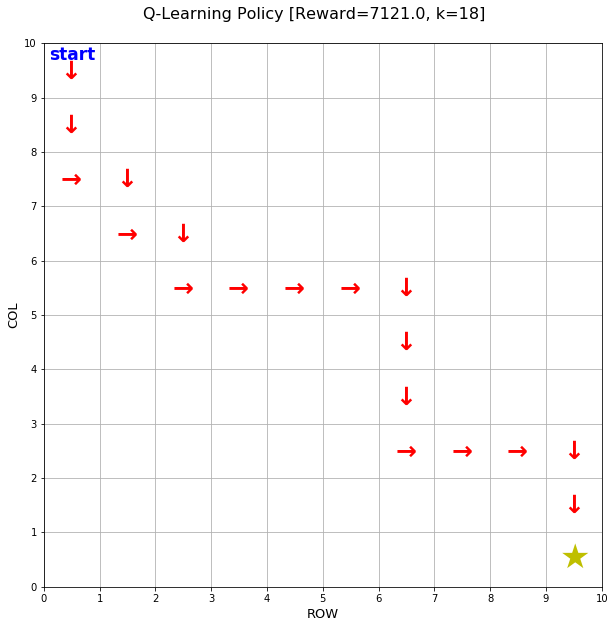


>>>>> RUN:1 <<<<<
Training...


Learning Completed!

>>>>> RUN:2 <<<<<
Training...


Learning Completed!

>>>>> RUN:3 <<<<<
Training...


Learning Completed!

>>>>> RUN:4 <<<<<
Training...


Learning Completed!

>>>>> RUN:5 <<<<<
Training...


Learning Completed!

>>>>> RUN:6 <<<<<
Training...


Learning Completed!

>>>>> RUN:7 <<<<<
Training...


Learning Completed!

>>>>> RUN:8 <<<<<
Training...


Learning Completed!

>>>>> RUN:9 <<<<<
Training...


Learning Completed!

RUN SUCCESS RATE 10/10 (100.00%)
SUCCESSFUL RUN EXECUTION TIME 0.0h:0.2m:43.82s
AVERAGE RUN EXECUTION TIME 0.0h:0.2m:43.82s
AVERAGE EXPLORE/EXPLOIT RATE 41.12%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Reward Discount Factor = 0.5
Epsilon/LR Decay Function: <function log_k_decay at 0x000000000F5F6268>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

>>>>> RUN:0 <<<<<
Training...


Learning Completed!

>>>>> RUN:1 <<<<<
Training...


Learning Completed!

>>>>> RUN:2 <<<<<
Training...


Learning Comple

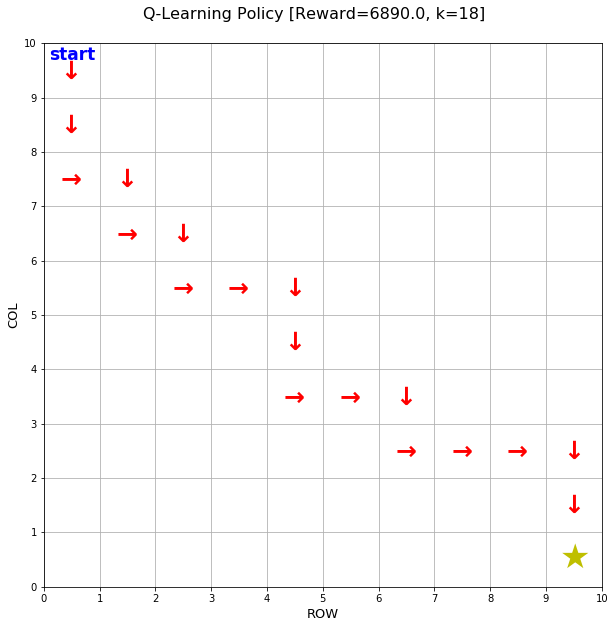


>>>>> RUN:1 <<<<<
Training...


Learning Completed!

>>>>> RUN:2 <<<<<
Training...


Learning Completed!

>>>>> RUN:3 <<<<<
Training...


Learning Completed!

>>>>> RUN:4 <<<<<
Training...


Learning Completed!

>>>>> RUN:5 <<<<<
Training...


Learning Completed!

>>>>> RUN:6 <<<<<
Training...


Learning Completed!

>>>>> RUN:7 <<<<<
Training...


Learning Completed!

>>>>> RUN:8 <<<<<
Training...


Learning Completed!

>>>>> RUN:9 <<<<<
Training...


Learning Completed!

RUN SUCCESS RATE 1/10 (10.00%)
SUCCESSFUL RUN EXECUTION TIME 0.0h:0.3m:1.08s
AVERAGE RUN EXECUTION TIME 0.0h:4.8m:23.23s
AVERAGE EXPLORE/EXPLOIT RATE 2.17%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Reward Discount Factor = 0.5
Epsilon/LR Decay Function: <function const_log_k_decay at 0x000000000F5F6378>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

>>>>> RUN:0 <<<<<
Training...


Learning Completed!

>>>>> RUN:1 <<<<<
Training...


Learning Completed!

>>>>> RUN:2 <<<<<
Training...


Learning Comp

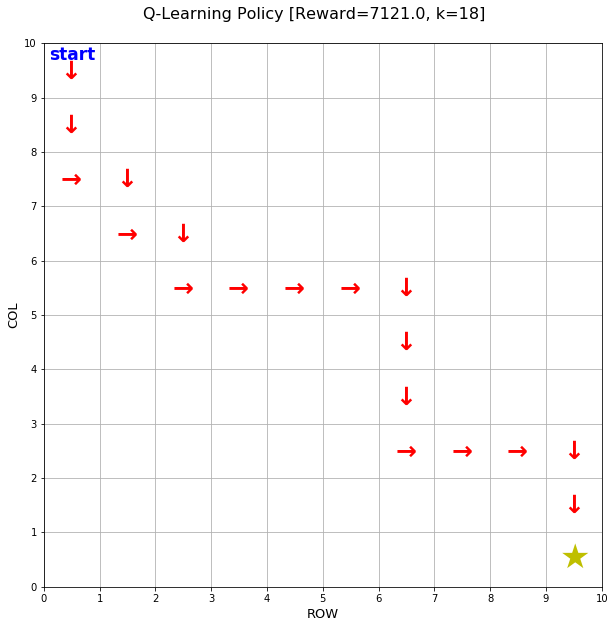


>>>>> RUN:1 <<<<<
Training...


Learning Completed!

>>>>> RUN:2 <<<<<
Training...


Learning Completed!

>>>>> RUN:3 <<<<<
Training...


Learning Completed!

>>>>> RUN:4 <<<<<
Training...


Learning Completed!

>>>>> RUN:5 <<<<<
Training...


Learning Completed!

>>>>> RUN:6 <<<<<
Training...


Learning Completed!

>>>>> RUN:7 <<<<<
Training...


Learning Completed!

>>>>> RUN:8 <<<<<
Training...


Learning Completed!

>>>>> RUN:9 <<<<<
Training...


Learning Completed!

RUN SUCCESS RATE 10/10 (100.00%)
SUCCESSFUL RUN EXECUTION TIME 0.0h:1.8m:26.16s
AVERAGE RUN EXECUTION TIME 0.0h:1.8m:26.16s
AVERAGE EXPLORE/EXPLOIT RATE 13.57%


In [11]:
# RUN EXPERIMENT
N = 10
teststates = []
greedystates = []
success_rates = []
for par_fn in Par_fn_list:
    for r_discount in R_discount_list:
        print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        print("Reward Discount Factor = {}".format(r_discount))
        print("Epsilon/LR Decay Function: {}".format(par_fn))
        print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
        run_success_rate = 0
        success_run_time = np.array([0.0,0.0,0.0])
        av_run_time = np.array([0.0,0.0,0.0])
        run_explr_explt_rate = 0.0
        for run in range(N):
            print("\n>>>>> RUN:{} <<<<<".format(run))
            (QL, opt_policy, opt_policy_coord, reward,
             greedy_policy, goal_reached, run_time,
             success_rate, explr_explt_rate) = perform_QL(state_grid_dim=(10,10), goal_state=(9,9), R_table=REWARD,
                                     idle_state=(0, 0), epsilon_fn=par_fn, LR_fn=par_fn,
                                     R_discount=r_discount, mode='qlearning', ST_TR_M=np.empty(0),
                                     action_trans_conf='standard', max_nb_trials=3000, verbose='False')
            run_explr_explt_rate += explr_explt_rate
            av_run_time += run_time
            
            if goal_reached:
                run_success_rate += goal_reached
                success_run_time += run_time
                if run_success_rate == 1:
                    print("\n>>> OPTIMAL POLICY FOUND <<<")
                    teststates.append([(opt_policy_coord[:,0]+1) + (opt_policy_coord[:,1]*10), reward])
                    greedystates.append(greedy_policy)
                    QL.display_policy(opt_policy, opt_policy_coord,
                                      reward, greedy_policy)
            
            if run == (N-1) and run_success_rate == 0:
                print("\n>>> NO OPTIMAL POLICY FOUND <<<")
                teststates.append([None, reward])
                greedystates.append(greedy_policy)
                
            if run == (N-1):
                run_explr_explt_rate /= N
                success_run_time = success_run_time / N
                av_run_time = av_run_time / N
                print("\nRUN SUCCESS RATE {}/{} ({:.2f}%)"
                      .format(run_success_rate, N, run_success_rate/N*100))
                print("SUCCESSFUL RUN EXECUTION TIME {}h:{}m:{:.2f}s"
                      .format(success_run_time[0], success_run_time[1], success_run_time[2]))
                print("AVERAGE RUN EXECUTION TIME {}h:{}m:{:.2f}s"
                      .format(av_run_time[0], av_run_time[1], av_run_time[2]))
                print("AVERAGE EXPLORE/EXPLOIT RATE {:.2f}%".format(run_explr_explt_rate))
                run_success_rate /= N
                success_rates.append(run_success_rate)

### Dynamic Programming


Mode is Dynamic Programming But No State Transition Model Provided!
Building Deterministic State Transition Model...

Starting Dynamic Programming...
Iter[1]: Q[sa] Update = 105525.83
Iter[4]: Q[sa] Update = 73687.17
Iter[7]: Q[sa] Update = 65735.68
Iter[10]: Q[sa] Update = 52035.80
Iter[13]: Q[sa] Update = 23351.48
Iter[16]: Q[sa] Update = 8128.75
Iter[19]: Q[sa] Update = 0.00

Q Convergence Achieved!

DYNAMIC PROGRAMMING CONFIGURATION:
    State Grid Dims = (10, 10):
      States: Idle = [(0, 0)] | Goal = [(9, 9)]
LEARNING RESULTS:
    Goal Reached = True
    Training Time: 0.0h:0.0m:0.11s | Iterations: 19

Greedy Policy(y, x):
[[2 2 2 2 2 1 2 2 2 2]
 [2 2 2 2 2 1 2 1 2 2]
 [1 2 2 2 2 1 2 1 2 2]
 [0 1 2 2 2 1 2 1 2 2]
 [1 1 1 1 1 1 2 1 2 2]
 [0 0 0 2 2 2 2 1 2 2]
 [1 1 1 2 2 1 2 1 2 2]
 [1 1 1 1 1 1 1 1 1 2]
 [1 1 2 2 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 0]]

 action['up'] = 0
 action['right'] = 1
 action['down'] = 2
 action['left'] = 3


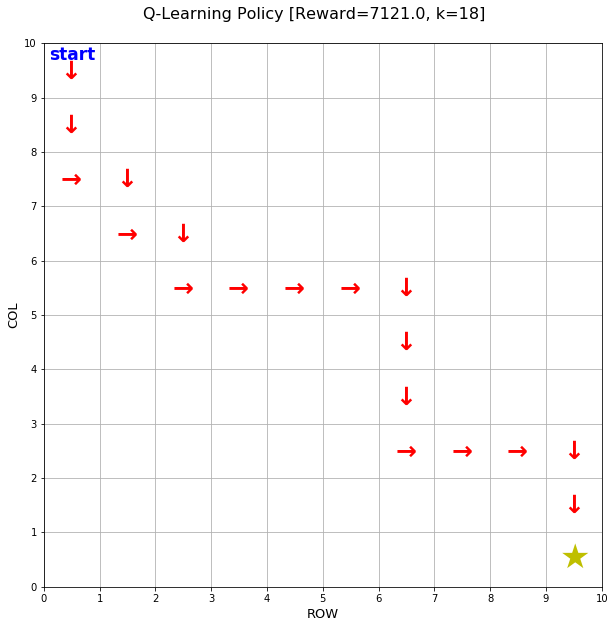

In [12]:
(QL, opt_policy, opt_policy_coord,
 reward, greedy_policy, goal_reached,
 run_time) = perform_QL(state_grid_dim=(10,10), goal_state=(9,9), R_table=REWARD,
                        idle_state=(0, 0), epsilon_fn=None, LR_fn=None,
                        R_discount=0.9, mode='dynamic_programming', ST_TR_M=np.empty(0),
                        action_trans_conf='standard', max_nb_trials=3000, verbose='medium')
if goal_reached:
    teststates.append([(opt_policy_coord[:,0]+1) + (opt_policy_coord[:,1]*10), reward])
else: teststates.append([None, reward])
greedystates.append(greedy_policy)
success_rates.append(1.0)

In [13]:
print(">>> OPTIMAL POLICY & REWARD <<<")
print(teststates)

>>> OPTIMAL POLICY & REWARD <<<
[[None, 13990.0], [None, 13745.0], [None, 13990.0], [array([  1,   2,   3,  13,  14,  24,  25,  35,  45,  55,  65,  66,  67,
        68,  78,  88,  98,  99, 100]), 7121.0], [None, 13990.0], [array([  1,   2,   3,  13,  14,  24,  25,  35,  45,  46,  47,  57,  67,
        68,  78,  88,  98,  99, 100]), 6890.0], [None, 13990.0], [array([  1,   2,   3,  13,  14,  24,  25,  35,  45,  55,  65,  66,  67,
        68,  78,  88,  98,  99, 100]), 7121.0], [array([  1,   2,   3,  13,  14,  24,  25,  35,  45,  55,  65,  66,  67,
        68,  78,  88,  98,  99, 100]), 7121.0]]


In [14]:
print(">>> SUCCESS RATES <<<")
print(success_rates)

>>> SUCCESS RATES <<<
[0.0, 0.0, 0.0, 1.0, 0.0, 0.1, 0.0, 1.0, 1.0]


## EXPERIMENT | EVALUATION

Would You Like to Perform Evaluation? (y/n)
y
Please Indicate if The Evaluation Args Are Correct? (y/n)
Filename:qeval.mat | Reward Data:qevalreward
n
Please Enter Filename
task1.mat
Please Enter Reward Data Variable Name
reward
>>>>>> REWARD MATRIX LOADED <<<<<<
Training...

Trial[1/3000]: Success = True, k = 55, Reward = 6403.0
                  Explore/Exploit[45/9]
Trial[151/3000]: Success = True, k = 105, Reward = 10842.0
                  Explore/Exploit[68/36]
Trial[301/3000]: Success = True, k = 129, Reward = 11966.0
                  Explore/Exploit[84/44]
Trial[451/3000]: Success = True, k = 115, Reward = 9885.0
                  Explore/Exploit[79/35]
Trial[601/3000]: Success = True, k = 129, Reward = 8959.0
                  Explore/Exploit[88/40]
Trial[751/3000]: Success = True, k = 95, Reward = 8526.0
                  Explore/Exploit[61/33]
Trial[901/3000]: Success = True, k = 87, Reward = 7256.0
                  Explore/Exploit[62/24]
Trial[1051/3000]: Success = True, 

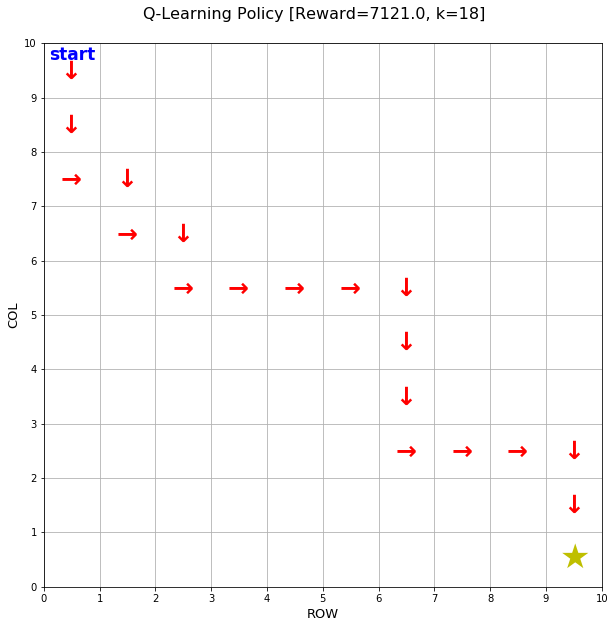


>>> QEVALSTATES <<<
[  1   2   3  13  14  24  25  35  45  55  65  66  67  68  78  88  98  99
 100]

Would You Like to Perform Dynamic Programming? (y/n)
y

Mode is Dynamic Programming But No State Transition Model Provided!
Building Deterministic State Transition Model...

Starting Dynamic Programming...
Iter[1]: Q[sa] Update = 105525.83
Iter[4]: Q[sa] Update = 73687.17
Iter[7]: Q[sa] Update = 65735.68
Iter[10]: Q[sa] Update = 52035.80
Iter[13]: Q[sa] Update = 23351.48
Iter[16]: Q[sa] Update = 8128.75
Iter[19]: Q[sa] Update = 0.00

Q Convergence Achieved!

DYNAMIC PROGRAMMING CONFIGURATION:
    State Grid Dims = (10, 10):
      States: Idle = [(0, 0)] | Goal = [(9, 9)]
LEARNING RESULTS:
    Goal Reached = True
    Training Time: 0.0h:0.0m:0.11s | Iterations: 19

Greedy Policy(y, x):
[[2 2 2 2 2 1 2 2 2 2]
 [2 2 2 2 2 1 2 1 2 2]
 [1 2 2 2 2 1 2 1 2 2]
 [0 1 2 2 2 1 2 1 2 2]
 [1 1 1 1 1 1 2 1 2 2]
 [0 0 0 2 2 2 2 1 2 2]
 [1 1 1 2 2 1 2 1 2 2]
 [1 1 1 1 1 1 1 1 1 2]
 [1 1 2 2 1 1 1 1 1 2

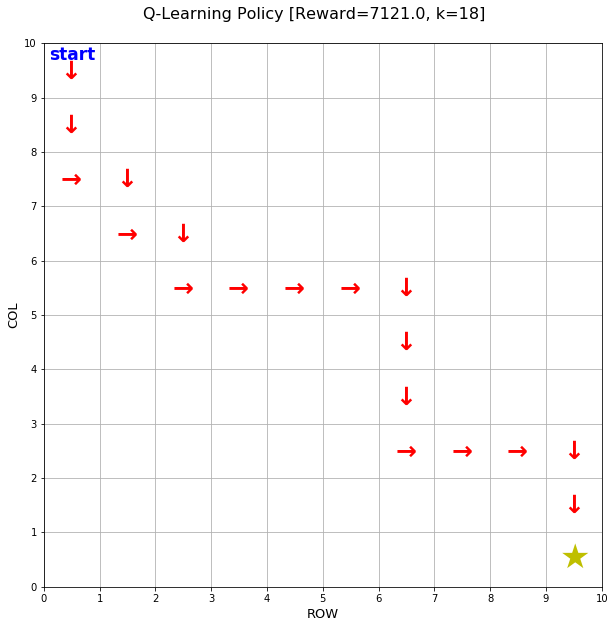

In [15]:
print("Would You Like to Perform Evaluation? (y/n)")
USER_I = input()
if(USER_I in ('yes', 'Yes', 'Y', 'y')):
    # Set the Dataset Args
    filename, reward_data = 'task1.mat', 'reward'
    print("Please Indicate if The Evaluation Args Are Correct? (y/n)")
    print("Filename:{} | Reward Data:{}".format(filename, reward_data))
    USER_I = input()
    if(USER_I not in ('yes', 'Yes', 'Y', 'y')):
        print("Please Enter Filename")
        filename = input()
        print("Please Enter Reward Data Variable Name")
        reward_data = input()
        
    # Get the Reward into NumPy arrays.
    REWARD_DICT = scipy.io.loadmat(filename)
    REWARD = np.array(REWARD_DICT[reward_data])
    print(">>>>>> REWARD MATRIX LOADED <<<<<<")
    
    # Perform Q-Learning
    (QL, opt_policy, opt_policy_coord, reward, greedy_policy,
     goal_reached, run_time, success_rate,
     explr_explt_rate) = perform_QL(state_grid_dim=(10,10), goal_state=(9,9), R_table=REWARD,
                                     idle_state=(0, 0), epsilon_fn=const_k_decay, LR_fn=const_k_decay,
                                     R_discount=0.9, mode='qlearning', ST_TR_M=np.empty(0),
                                     action_trans_conf='standard', max_nb_trials=3000, verbose='medium')
    qevalstates = (opt_policy_coord[:,0]+1) + (opt_policy_coord[:,1]*10)
    
    print("\n>>> QEVALSTATES <<<")
    print(qevalstates)
    print()
    
    # Perform Dynamic Programming
    print("Would You Like to Perform Dynamic Programming? (y/n)")
    USER_I = input()
    if(USER_I in ('yes', 'Yes', 'Y', 'y')):
        (QL, opt_policy, opt_policy_coord,
         reward, greedy_policy, goal_reached,
         run_time) = perform_QL(state_grid_dim=(10,10), goal_state=(9,9), R_table=REWARD,
                                idle_state=(0, 0), epsilon_fn=None, LR_fn=None,
                                R_discount=0.9, mode='dynamic_programming', ST_TR_M=np.empty(0),
                                action_trans_conf='standard', max_nb_trials=3000, verbose='high')